# Extract Comments


In [14]:
import gzip
import pandas as pd
import feather
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [8]:
COMMENTS = 'DATA/youtube_comments.tsv.gz'
HELPERMD = 'data/yt_metadata_helper.feather'
METADATA = 'data/yt_metadata_en.jsonl.gz'
MERGEDHELPERCOMM = 'data/mergedmetadatacomments.csv'
MERGEDTAGSCOMM = 'finalgamingtagcomment.parquet'
METADATAFILTERED = 'allmtdt.parquet'

COMMENTS is 77GB, we do not have the processing capacity to extract all the data, we are planning on ways to extract it for the next milestone but to make the first analysis, we decided to sample it by taking the first 100M comments (7B comments in the file). The data is sorted by author ID so authors are grouped. 

This observation helps us in our analysis by knowing that we eon't have missing data per author treated.

In [5]:

commentstoextract = 100000000

# Utilisez gzip pour décompresser le fichier
with gzip.open(COMMENTS, 'rt', encoding='utf-8') as f:
    # Utilisez pandas pour charger le fichier TSV dans un DataFrame
    df_comm = pd.read_csv(f, sep='\t', nrows=commentstoextract
                        )

# Affichez les premières lignes du DataFrame pour vérifier
df_comm.drop(columns=['likes','replies'])
df_comm.head()

,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0


# Extract Helper YT_Metadata


In [4]:
df_helper = feather.read_dataframe(HELPERMD)

In [5]:
df_helper.head()

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0


***YT_Metadata Analysis***

Let's plot the number of videos per category, and the uploads per category through time 

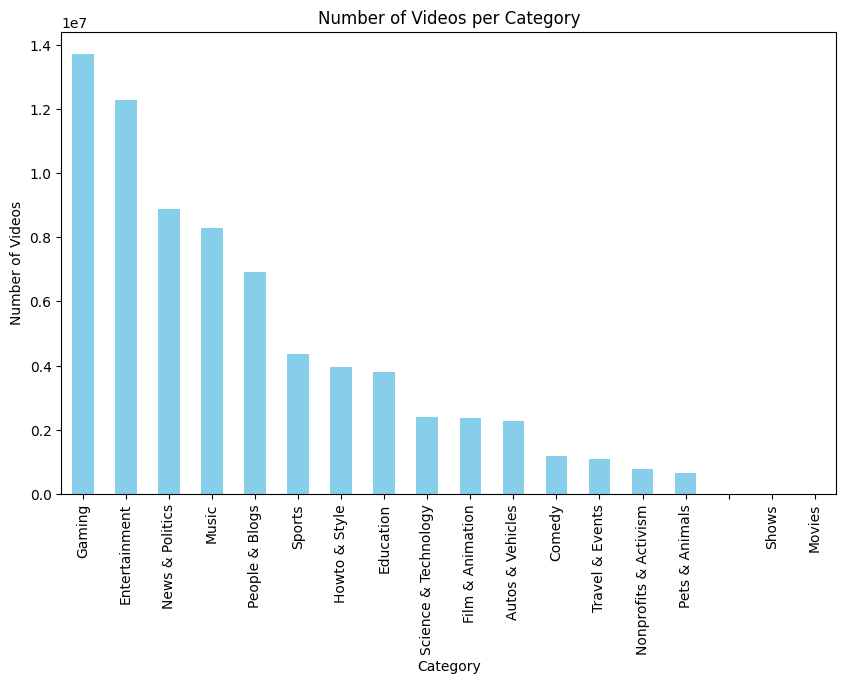

In [6]:

# Plot the number of videos per category
videos_per_category = df_helper['categories'].value_counts()
videos_per_category.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Videos per Category')
plt.xlabel('Category')
plt.ylabel('Number of Videos')
plt.show()


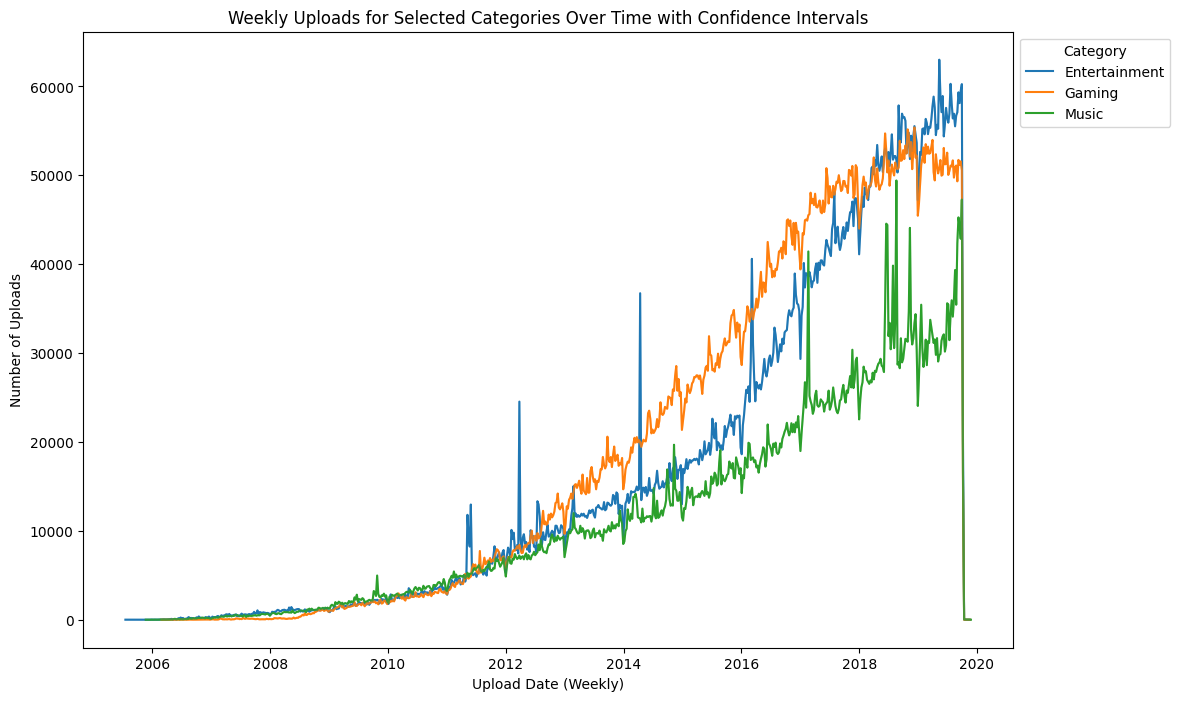

In [8]:

# Plot the uploads per category through time

# Convert the 'upload_date' column to datetime format
df_helper['upload_date'] = pd.to_datetime(df_helper['upload_date'])
# Filter the DataFrame for the selected categories
selected_categories = ['Gaming', 'Entertainment', 'Music']
selected_df = df_helper[df_helper['categories'].isin(selected_categories)]

# Resample the data to get weekly counts
weekly_uploads = selected_df.groupby(['categories', pd.Grouper(key='upload_date', freq='W-Mon')])['display_id'].count().reset_index()

# Plot the weekly uploads for selected categories with confidence intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=weekly_uploads, x='upload_date', y='display_id', hue='categories')

# Add confidence intervals
sns.lineplot(data=weekly_uploads, x='upload_date', y='display_id', hue='categories', errorbar='sd', legend=False, alpha=0.2)

plt.title('Weekly Uploads for Selected Categories Over Time with Confidence Intervals')
plt.xlabel('Upload Date (Weekly)')
plt.ylabel('Number of Uploads')
plt.legend(title='Category', bbox_to_anchor=(1, 1))
plt.show()

As gaming category has the most comments, we can see that at the end of the crawling, entertainment content passed it. We can see that for example, Big Youtubeurs like PewDiePie did also the same transition from gaming to entertainment, thiws phenomenon is maybe explained by the fact that people are getting older and less interested in gaming, so channels will have to convert in order to maintain their audience. 

But in general categories ar growing in the same way and reflect the general popularity of youtube, which has grown enormously over this period.

# Merging YT_Metadata and Comments 

In [ ]:

df_comm = df_comm.rename(columns={'video_id': 'display_id'})
df_merged = pd.merge(df_comm, df_helper, on='display_id', how='left')
df_merged.head()

In [9]:
df_merged.to_csv(MERGEDHELPERCOMM, index=False)


In [18]:
df_merged = pd.read_csv(MERGEDHELPERCOMM)


In [4]:
df_merged.head()

,author,display_id,likes,replies,categories,channel_id,dislike_count,duration,like_count,upload_date,view_count
0,1,Gkb1QMHrGvA,2,0,People & Blogs,UCBXNpF6k2n8dsI6nBH8q4sQ,7708.0,478,85133.0,2019-06-01,11659189.0
1,1,CNtp0xqoods,0,0,Entertainment,UCpB959t8iPrxQWj7G6n0ctQ,1859.0,815,111451.0,2019-04-06,3807677.0
2,1,249EEzQmVmQ,1,0,Entertainment,UCpB959t8iPrxQWj7G6n0ctQ,1643.0,697,84571.0,2019-09-15,2679538.0
3,1,_U443T2K_Bs,0,0,Comedy,UCM2ERkgV3P1_6MAyxa51rxA,3287.0,990,41195.0,2019-08-03,1235364.0
4,1,rJbjhm0weYc,0,0,People & Blogs,UCtwD0AlYSlAYv7eXu8UxtEg,1740.0,603,18827.0,2019-09-11,914335.0


Let's keep only interesting columns for our research 

In [19]:
df_mergednew = df_merged.loc[:, ['display_id', 'author', 'replies','likes','categories']]
df_mergednew.head()


,display_id,author,replies,likes,categories
0,Gkb1QMHrGvA,1,0,2,People & Blogs
1,CNtp0xqoods,1,0,0,Entertainment
2,249EEzQmVmQ,1,0,1,Entertainment
3,_U443T2K_Bs,1,0,0,Comedy
4,rJbjhm0weYc,1,0,0,People & Blogs


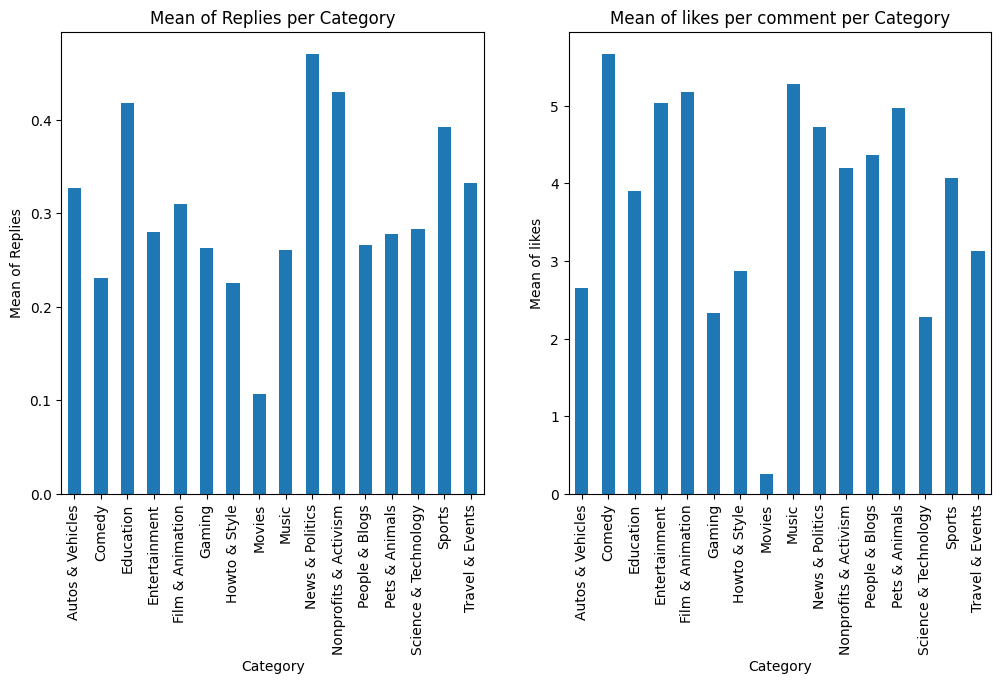

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

df_replies_per_video = df_mergednew.groupby(['categories'])['replies'].mean()
df_replies_per_video.plot(kind='bar', ax=ax1)
ax1.set_title('Mean of Replies per Category')
ax1.set_xlabel('Category')
ax1.set_ylabel('Mean of Replies')

df_likes_per_video = df_mergednew.groupby(['categories'])['likes'].mean()
df_likes_per_video.plot(kind='bar', ax=ax2)
ax2.set_title('Mean of likes per comment per Category')
ax2.set_xlabel('Category')
ax2.set_ylabel('Mean of likes')

plt.show()


In [20]:
df_author_categories = df_mergednew.groupby(['author', 'categories']).size().reset_index(name='count')
df_author_categories.head()
df_author_categories['count_sum'] = df_author_categories.groupby('author')['count'].transform('sum')
df_author_categories['count_ratio'] = df_author_categories['count'] / df_author_categories['count_sum']
df_author_categories.head()

df_author_categories = df_author_categories.drop(columns=[ 'count_sum'])
df_author_categories.head()

,author,categories,count,count_ratio
0,1,Comedy,1,0.200000
1,1,Entertainment,2,0.400000
2,1,People & Blogs,2,0.400000
3,2,Gaming,2,0.666667
4,2,Howto & Style,1,0.333333


In [15]:
categories_to_keep = ['Gaming', 'Music', 'News & Politics', 'Science & Technology', 'Sports','Howto & Style']
df_author_categories_filtered = df_author_categories[df_author_categories['categories'].isin(categories_to_keep)]
df_author_categories_filtered.head()

,author,categories,count,count_ratio
3,2,Gaming,2,0.666667
4,2,Howto & Style,1,0.333333
8,4,News & Politics,1,0.166667
9,4,Science & Technology,1,0.166667
10,5,Gaming,2,0.666667


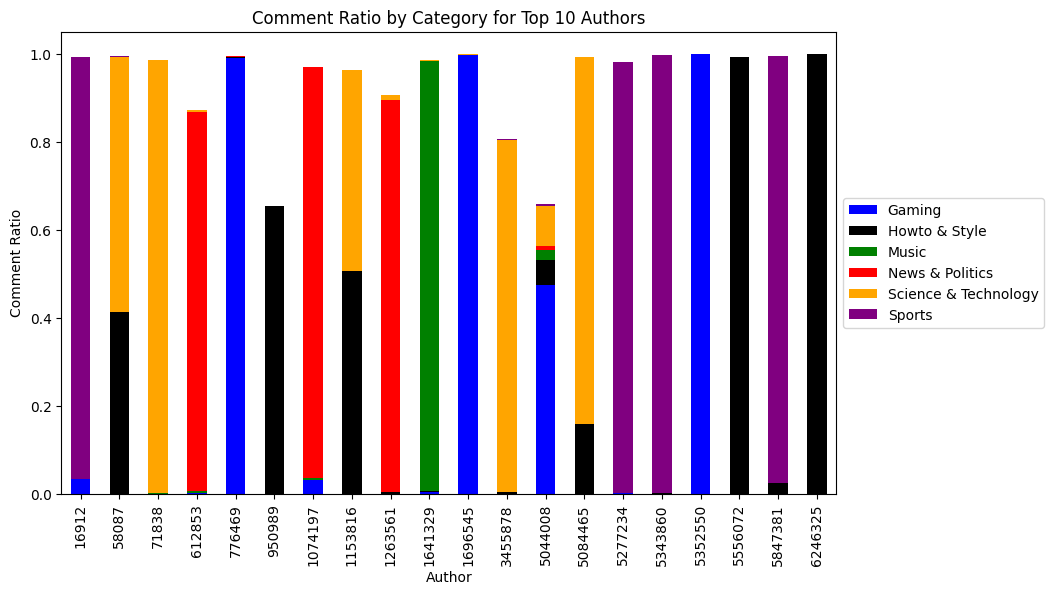

In [16]:

# Define colors for each category
colors = {'Gaming': 'blue', 'Music': 'green', 'News & Politics': 'red', 'Science & Technology': 'orange', 'Sports': 'purple','Howto & Style':'black'}
# pick top 10 authors by comment count
top_authors = df_author_categories_filtered.groupby('author')['count'].sum().sort_values(ascending=False).head(20).index.tolist()

# filter the dataframe to only include the top 10 authors
df_top_authors = df_author_categories_filtered[df_author_categories_filtered['author'].isin(top_authors)]

# create a pivot table to prepare data for stacked plot
df_pivot = df_top_authors.pivot(index='author', columns='categories', values='count_ratio')

# plot the stacked plot
fig, ax = plt.subplots(figsize=(10, 6))
df_pivot.plot(kind='bar', stacked=True, ax=ax, color=[colors[c] for c in df_pivot.columns])

plt.title('Comment Ratio by Category for Top 10 Authors')
plt.xlabel('Author')
plt.ylabel('Comment Ratio')

# move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()


In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


df = df_author_categories_filtered

# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for _, row in df.iterrows():
    G.add_node(row['categories'])
    G.nodes[row['categories']]['count'] = row['count']
    G.nodes[row['categories']]['count_ratio'] = row['count_ratio']

# Add edges based on common authors
for _, group in df.groupby('author'):
    categories = group['categories'].tolist()
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            if G.has_edge(categories[i], categories[j]):
                G[categories[i]][categories[j]]['weight'] += 1
            else:
                G.add_edge(categories[i], categories[j], weight=1)

# Draw the graph
pos = nx.spring_layout(G, k=2)  # You can adjust the k parameter to increase or decrease the distance between nodes
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='lightblue')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


# Extract YT_Metadata

In [ ]:
# Replace 'your_file.jsonl.gz' with the actual file path
file_path = METADATA

for i in range(8):
    # Specify the number of chunks to skip
    chunks_to_skip = i*1000
    chunk_size = 10000
    counter = 0
    # Create a list to store DataFrames
    chunks = []

    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        for _ in tqdm(islice(file, chunks_to_skip * chunk_size)):
            pass

        # Read the remaining data in chunks
        for chunk_df in tqdm(pd.read_json(file, lines=True, chunksize=chunk_size)):
            counter += 1
            if counter > 1000:
                break
            # Keep only rows with categories equal to gaming
            chunk_df = chunk_df[chunk_df['categories'] == 'Gaming']
            chunk_df = chunk_df.drop(columns=['description','title','view_count','dislike_count','channel_id','like_count','crawl_date','duration'])

            chunks.append(chunk_df)

    # Concatenate all chunks into a single DataFrame
    df = pd.concat(chunks, ignore_index=True)
    # Specify the path where you want to save the Parquet file
    parquet_file_path = f'output_file{i}.parquet'
    # Save the DataFrame to a Parquet file
    df.to_parquet(parquet_file_path, index=False)
    # Display the DataFrame
    print(f"Parquet file {i} saved successfully!")
    del df


In [ ]:


dfs = pd.DataFrame()

for i in tqdm(range(8)):
    file= f'output_file{i}.parquet'
    dfn = pd.read_parquet(file)
    dfs = pd.concat([dfs, dfn], ignore_index=True)
    del dfn
    
# Specify the path where you want to save the Parquet file
parquet_file_path = METADATAFILTERED
print('prq')
    # Save the DataFrame to a Parquet file
dfs = dfs.drop(columns=['categories'])

dfs.to_parquet(parquet_file_path, index=False)
    # Display the DataFrame

dfs.head()

In [9]:
df_tagsmetadata = pd.read_parquet(METADATAFILTERED)


In [ ]:
merged_commtags = pd.merge(df_comm, df_tagsmetadata, on='display_id', how='left')
merged_commtags.to_parquet(MERGEDTAGSCOMM, index=False)


In [10]:
merged_commtags = pd.read_parquet(MERGEDTAGSCOMM)

In [11]:

# Define colors for each category
colors = {'call of duty':'black','fifa': 'blue', 'pes': 'green', 'fortnite': 'red', 'league of legends': 'orange', 'minecraft': 'purple'}

frames = {tag: merged_commtags[merged_commtags['tags'].str.contains(tag, case=False)] for tag in tqdm(colors)}

print(frames)

100%|██████████| 6/6 [04:50<00:00, 48.37s/it]

{'call of duty':            author   display_id  likes  replies  \
41             16  P4soUB4N_7Y      0        0   
114            16  9BRuBptSTMk      0        0   
221            16  -D7KM5S4j94      0        0   
249            16  P4soUB4N_7Y      0        0   
259            16  _zLovAyL6YA      2        0   
...           ...          ...    ...      ...   
25658509  6695065  iO923YxI9OA      0        0   
25658639  6695100  GY4cFGgD7U0      0        0   
25658642  6695100  AinJbYHmnJo      0        0   
25658646  6695100  UOOVBatsYzY      1        0   
25658649  6695100  2mIlFC52bqc      0        0   

                                                       tags  \
41        Call of Duty Mobile,Call of Duty on Mobile,COD...   
114       apex legends gameplay,fortnite,battle royale,h...   
221       iferg,HawksNest,NoahFromYoutube,call of duty m...   
249       Call of Duty Mobile,Call of Duty on Mobile,COD...   
259       PUBG,playerunknowns,battlegrounds,battle royal...   
... 

[776469, 5352550, 1696545, 1292014, 245876, 1055762, 5293067, 88509, 5044008, 984236, 6043096, 1460299, 5093025, 5810387, 254985, 5413642, 3763738, 6479682, 3894841, 805578, 3995691, 607805, 573121, 2897270, 676865, 6147303, 2708987, 2433456, 3945672, 4356122]


100%|██████████| 6/6 [00:00<00:00, 14.05it/s]


        call of duty fifa  pes fortnite league of legends minecraft
776469            13    0    1        0                 0         1
5352550            0    0    0        0                 0         1
1696545            0    0   37        0                 0      6226
1292014            0    0  514        0                 0        37
245876           150    1   18        1                 0      1219
1055762            0    0    2        3                 0     10456
5293067            0    0   59        0                 0        13
88509            239    0    0      445                 0         4
5044008          548    2  215     3801                19       686
984236            31   12  101       52                13        14
6043096           79   27  220       52                27        91
1460299            0    0    0        1                 0         0
5093025            0    0   11        2                 0      5078
5810387            0    0    0        0         

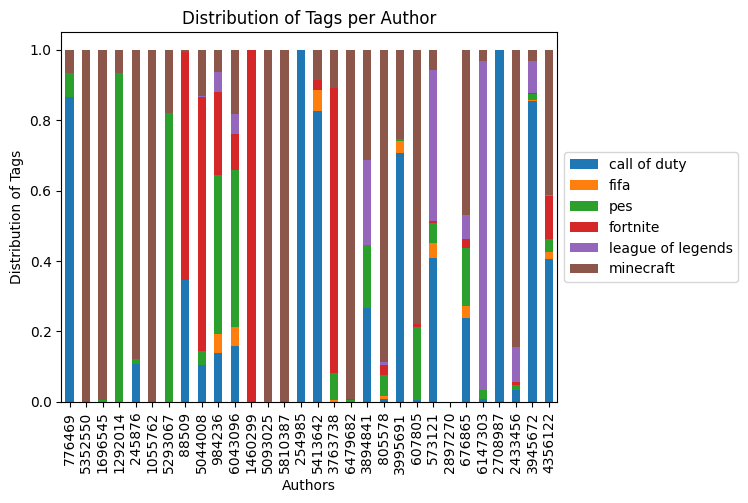

In [12]:

# Define the authors to count
authors = merged_commtags['author'].value_counts().head(30).index.tolist()
print(authors)

# Define colors for each category

# Create a dictionary to store the results
results = {}

# Loop through each category
for tag, color in tqdm(colors.items()):
    # Filter the data to keep only rows with the current category
    df = frames[tag]
    # Count the number of occurrences of each author
    counts = df['author'].value_counts()
    # Keep only the counts for the specified authors
    counts = counts.reindex(authors, fill_value=0)
    # Store the counts in the results dictionary
    results[tag] = counts



# Display the updated dataframe


# Create an empty dataframe to store the results
df = pd.DataFrame(columns=colors.keys(), index=authors)

# Loop through each author
for author in authors:
    # Loop through each category
    for tag in colors.keys():
        # Get the count for the current author and category
        count = results[tag][author]
        # Add the count to the dataframe
        df.at[author, tag] = count

# Display the dataframe
print(df)
# Loop through each row
for index, row in df.iterrows():
    # Divide each value in the row by the sum of the row
    row_sum = row.sum()
    df.loc[index] = row / row_sum

df.plot(kind='bar', stacked=True, legend=False)
plt.xlabel('Authors')
plt.ylabel('Distribution of Tags')
plt.title('Distribution of Tags per Author')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()



[4050565, 140953, 6324417, 2997605, 759373, 1274702, 4205878, 2587193, 3328716, 4869978, 2390693, 4779603, 5735003, 5026345, 2470736, 5103401, 1847888, 3596844, 1598989, 3481159, 4490502, 1834932, 79560, 6408371, 2980557, 1534698, 6156208, 4789589, 5324139, 1366721]


100%|██████████| 6/6 [00:00<00:00, 44.11it/s]

        call of duty fifa pes fortnite league of legends minecraft
4050565            0    0   0        0                 0         0
140953             0    0   0        0                 0         0
6324417            0    0   0        0                 0         0
2997605            0    0   0        0                 0         0
759373             0    0   0        0                 0         0
1274702            0    0   0        0                 0         0
4205878            0    0   0        0                 0         0
2587193            0    0   0        0                 0         1
3328716            0    1   0        0                 0         0
4869978            0    0   0        1                 0         0
2390693            0    0   0        0                 0         0
4779603            0    0   0        0                 0        12
5735003            0    0   0        4                 0         1
5026345            0    0   0        0                 0      

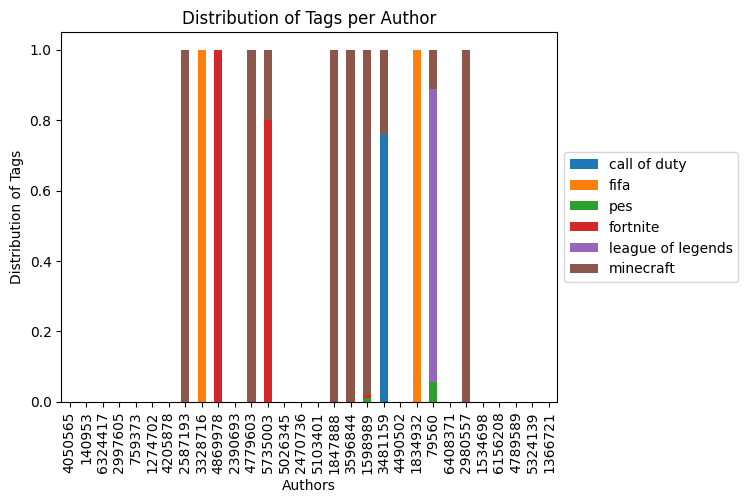

In [15]:
authors = list(merged_commtags['author'].unique())
random.shuffle(authors)
authors = authors[:30]

# Define colors for each category

# Create a dictionary to store the results
results = {}

# Loop through each category
for tag, color in tqdm(colors.items()):
    # Filter the data to keep only rows with the current category
    df = frames[tag]
    # Count the number of occurrences of each author
    counts = df['author'].value_counts()
    # Keep only the counts for the specified authors
    counts = counts.reindex(authors, fill_value=0)
    # Store the counts in the results dictionary
    results[tag] = counts



# Display the updated dataframe


# Create an empty dataframe to store the results
df = pd.DataFrame(columns=colors.keys(), index=authors)

# Loop through each author
for author in authors:
    # Loop through each category
    for tag in colors.keys():
        # Get the count for the current author and category
        count = results[tag][author]
        # Add the count to the dataframe
        df.at[author, tag] = count
df.head()
# Loop through each row
for index, row in df.iterrows():
    # Divide each value in the row by the sum of the row
    row_sum = row.sum()
    df.loc[index] = row / row_sum

df.plot(kind='bar', stacked=True, legend=False)
plt.xlabel('Authors')
plt.ylabel('Distribution of Tags')
plt.title('Distribution of Tags per Author')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()



Filtered data to keep only rows with "call of duty" in tags
Filtered data to keep only rows with "fifa" in tags
Filtered data to keep only rows with "pes" in tags
Filtered data to keep only rows with "fortnite" in tags
Filtered data to keep only rows with "league of legends" in tags
Filtered data to keep only rows with "minecraft" in tags


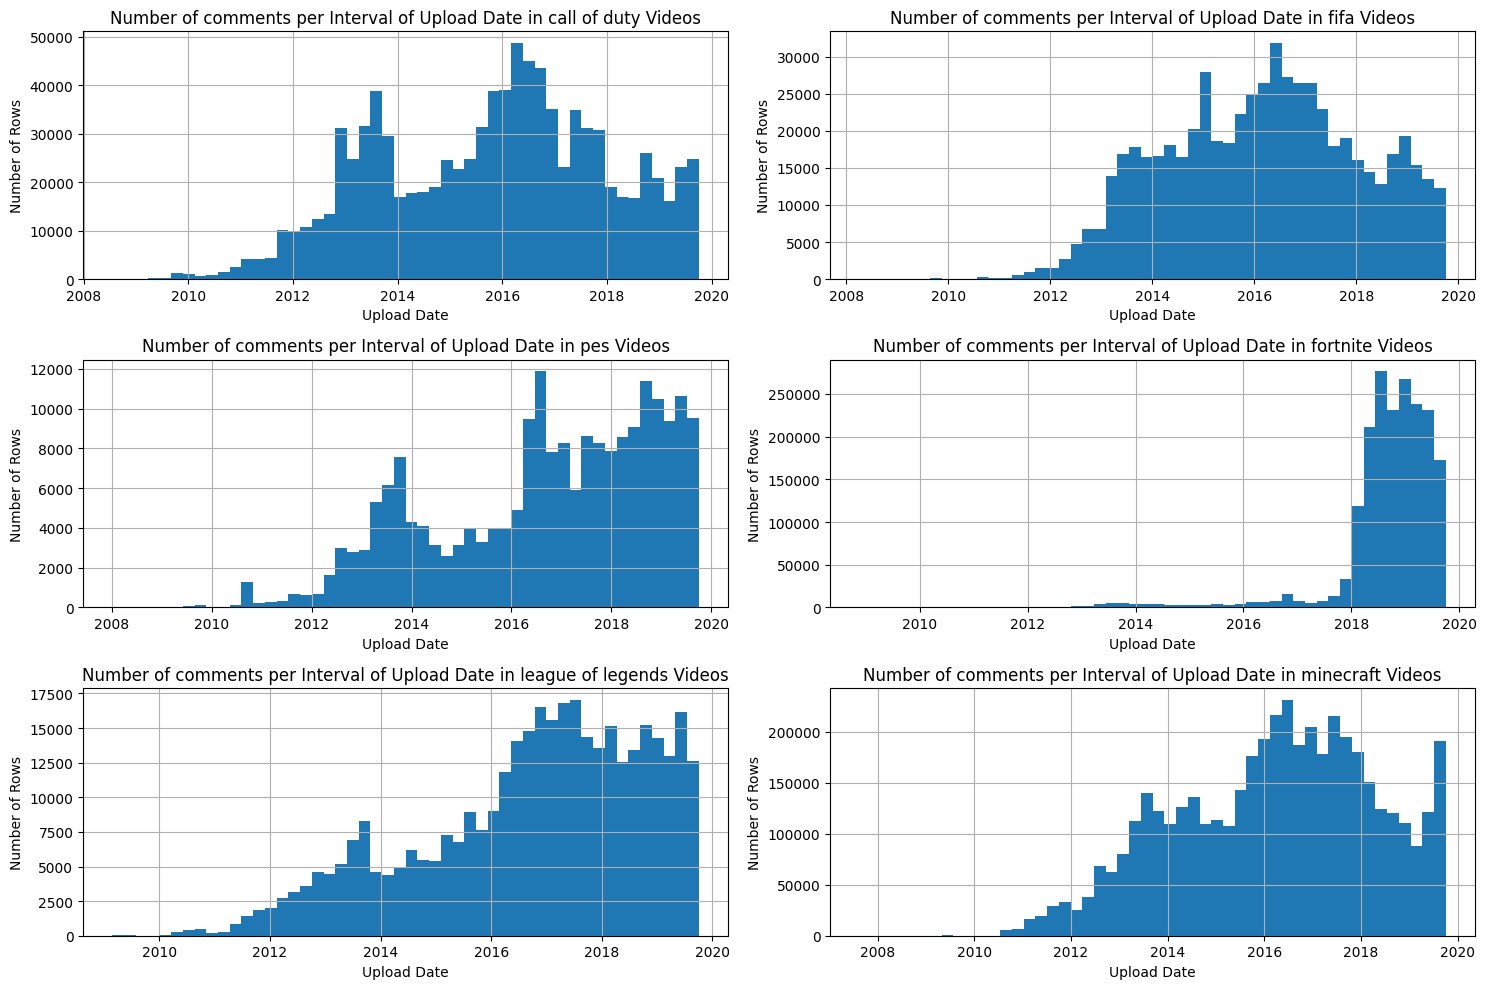

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Define the tags to plot
tags = ['call of duty', 'fifa', 'pes', 'fortnite', 'league of legends', 'minecraft']

# Loop through each tag and axis
for tag, ax in zip(tags, axes.flatten()):
    # Filter the data and plot the histogram
    a = merged_commtags[merged_commtags['tags'].str.contains(tag, case=False)]
    print(f'Filtered data to keep only rows with "{tag}" in tags')
    a = a.sort_values(by='upload_date')
    a['upload_date'] = pd.to_datetime(a['upload_date'])
    a.hist(column='upload_date', bins=50, figsize=(15, 10), ax=ax)
    ax.set_xlabel('Upload Date')
    ax.set_ylabel('Number of Rows')
    ax.set_title(f'Number of comments per Interval of Upload Date in {tag} Videos')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
